In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e3', 'e4', 'e5', 'e6']
#aedge='orange'

#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
df = pd.read_pickle('CCPA.pkl.gz')

In [9]:
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [10]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [11]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

In [12]:
#d = cp.generate_decline(dfc, scale=False)

In [13]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='1d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    maxday = t.loc[t[value_col] == t[value_col].max(), x_col].values[0]
    t.loc[:, x_col] = t.loc[:, x_col] - maxday

    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [14]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = dfc.groupby(groupby_cols).apply(convert_func).reset_index() 

In [15]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds.loc[(ds.day < 81) & (ds.day > -11)]

In [16]:
ds.head()

experiment_sample experiment sample      PRO ALT     culture  day     FL
9            e3, 10A         e3    10A  MIT0604  DE  Co_Culture  -10  0.299
10           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -9  0.381
11           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -8  0.693
12           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -7  0.959
13           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -6  1.225

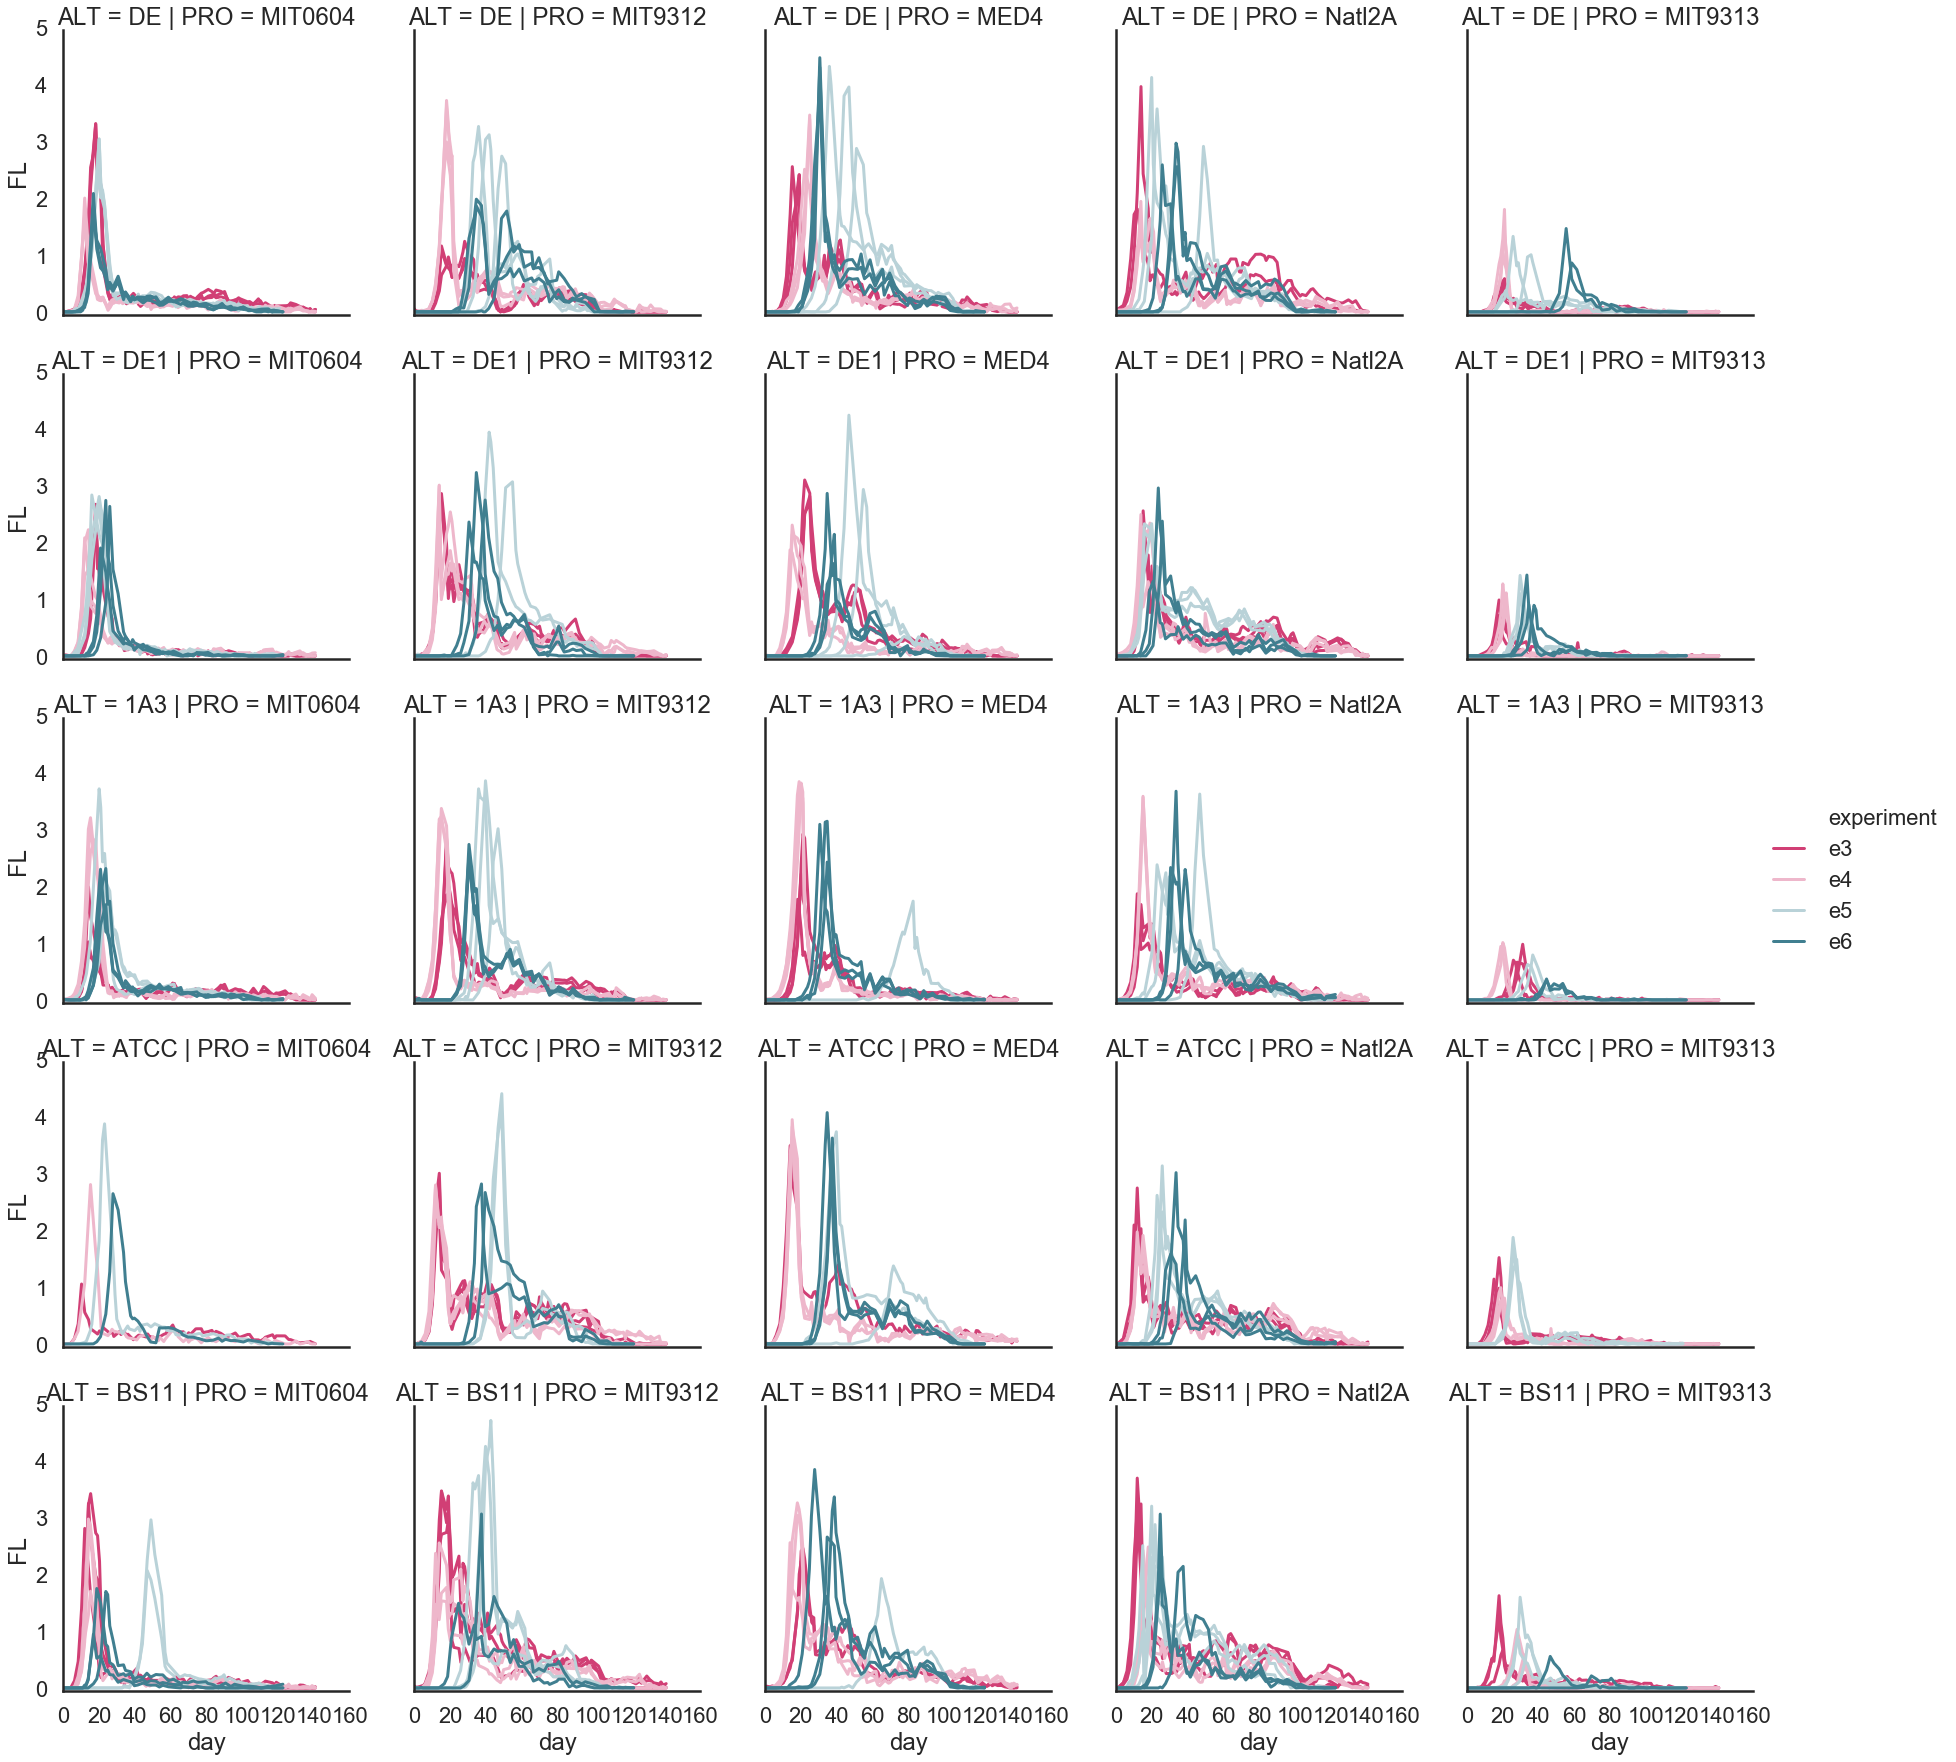

In [17]:
sns.relplot(data=dfc, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT', row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

(<seaborn.axisgrid.FacetGrid at 0x23e93bd9908>,)

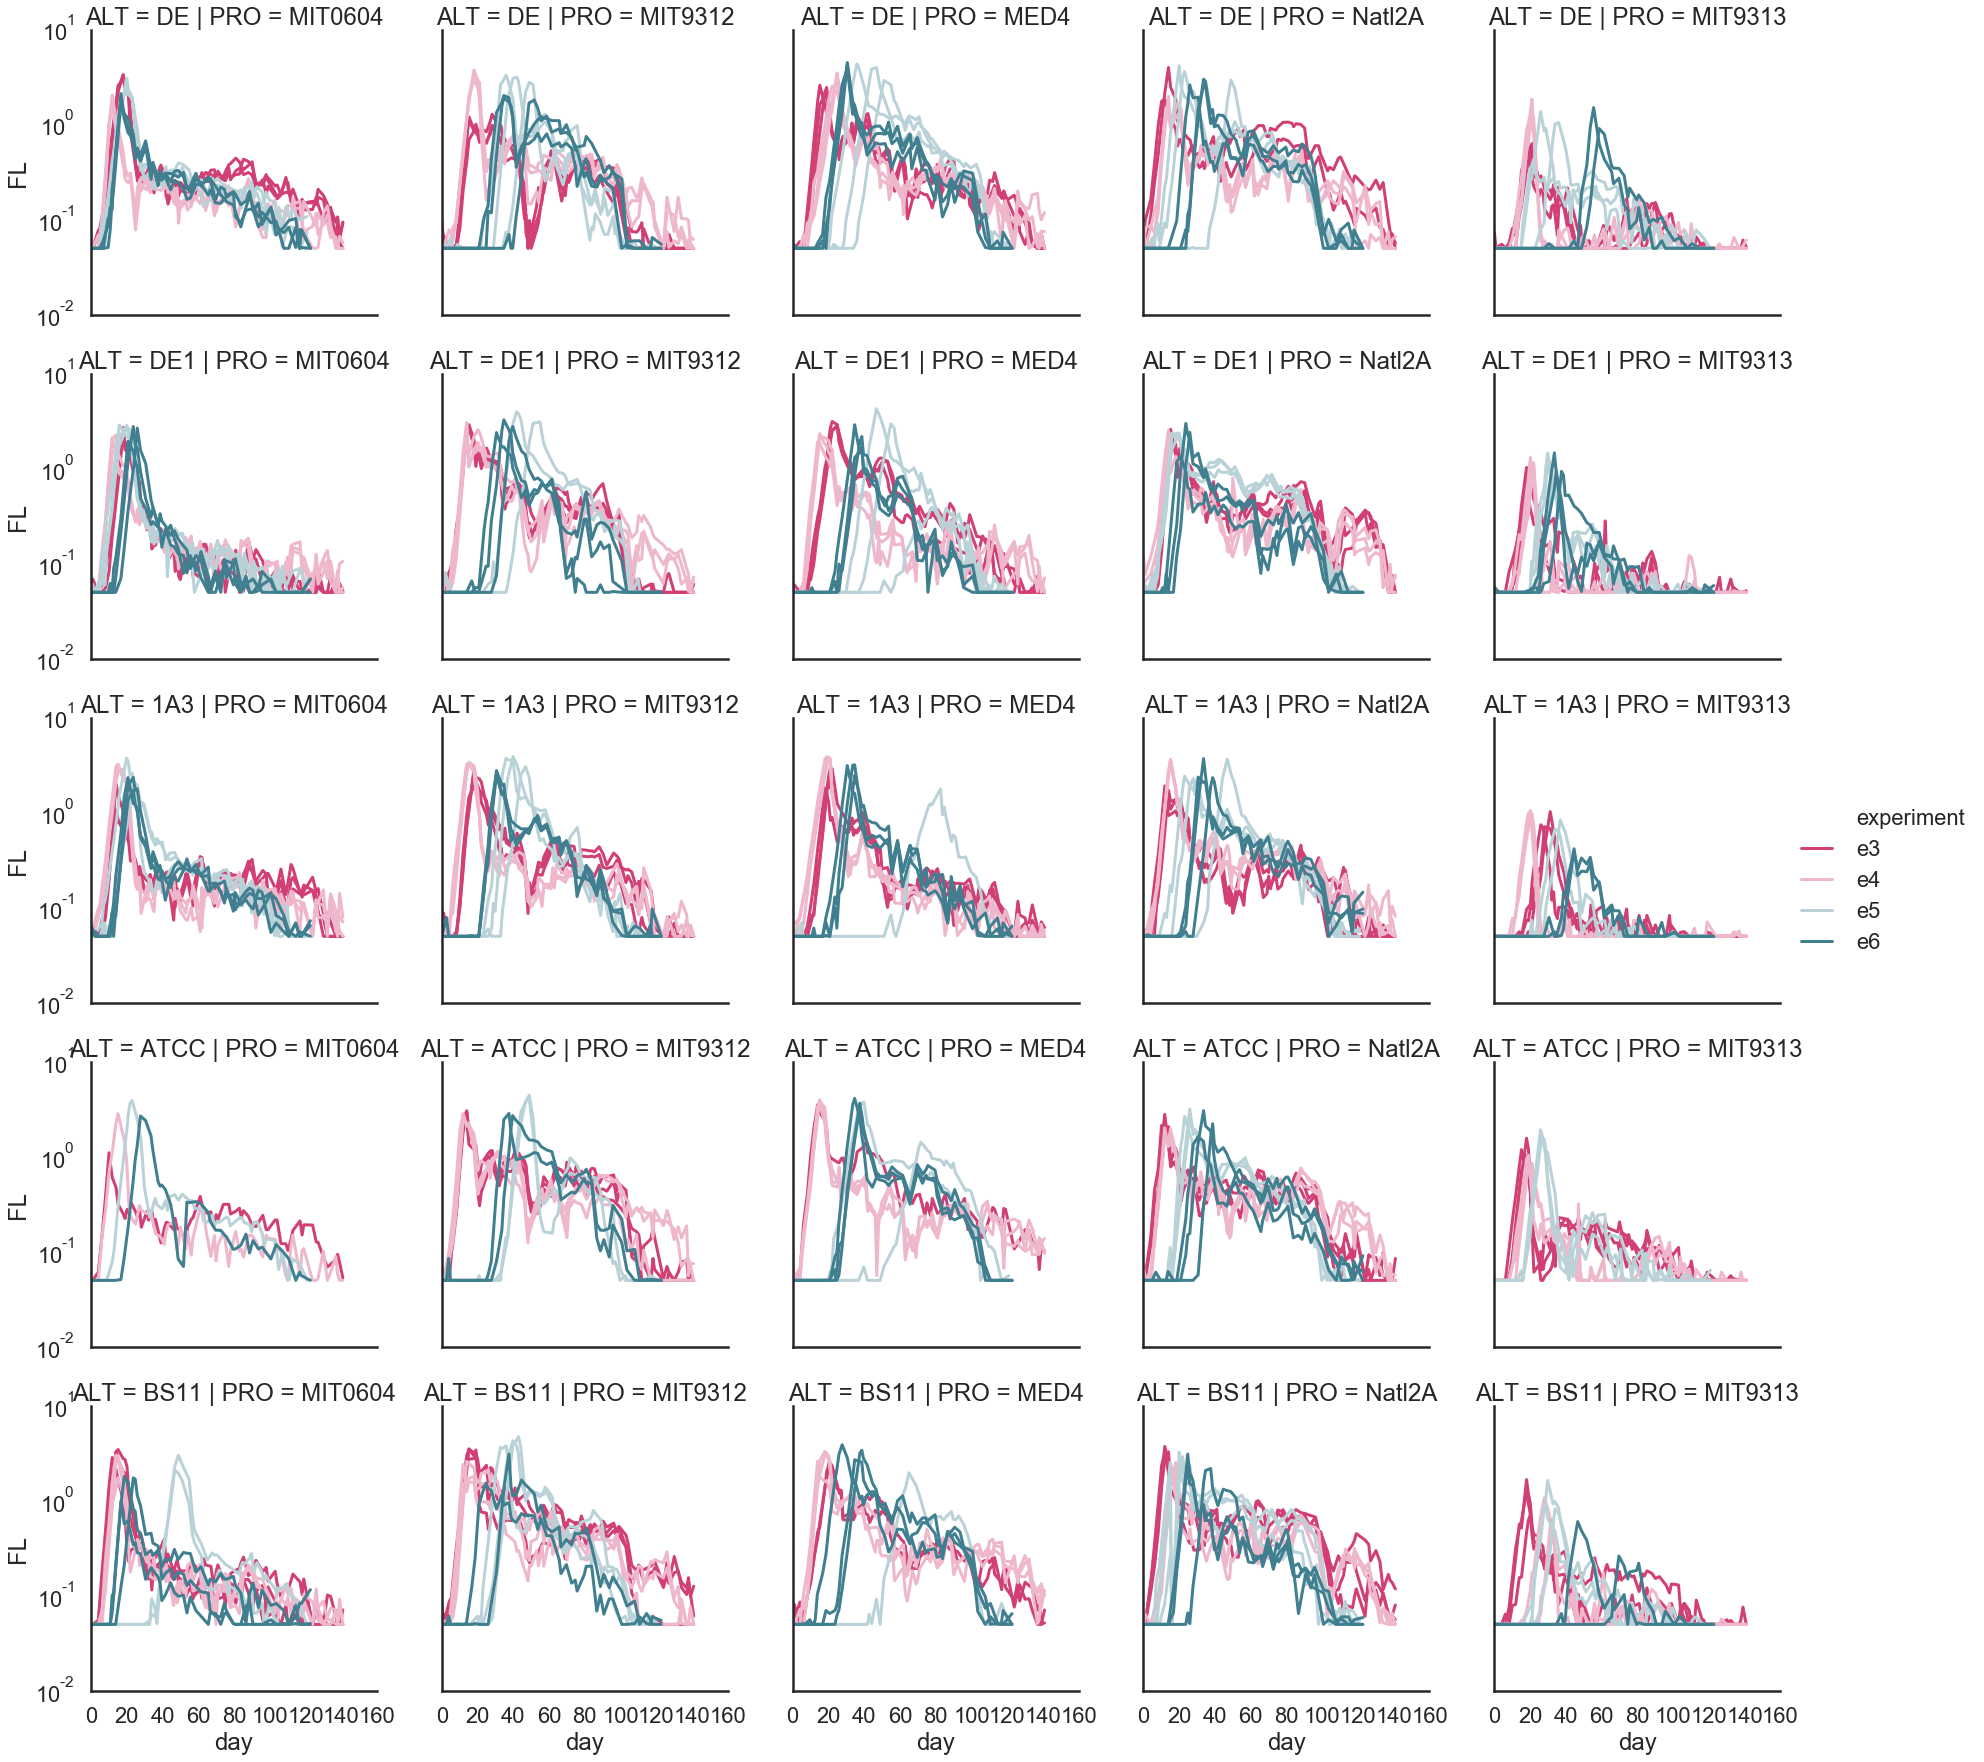

In [85]:
g= sns.relplot(data=dfc, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT', row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)
g.set(yscale="log"), 

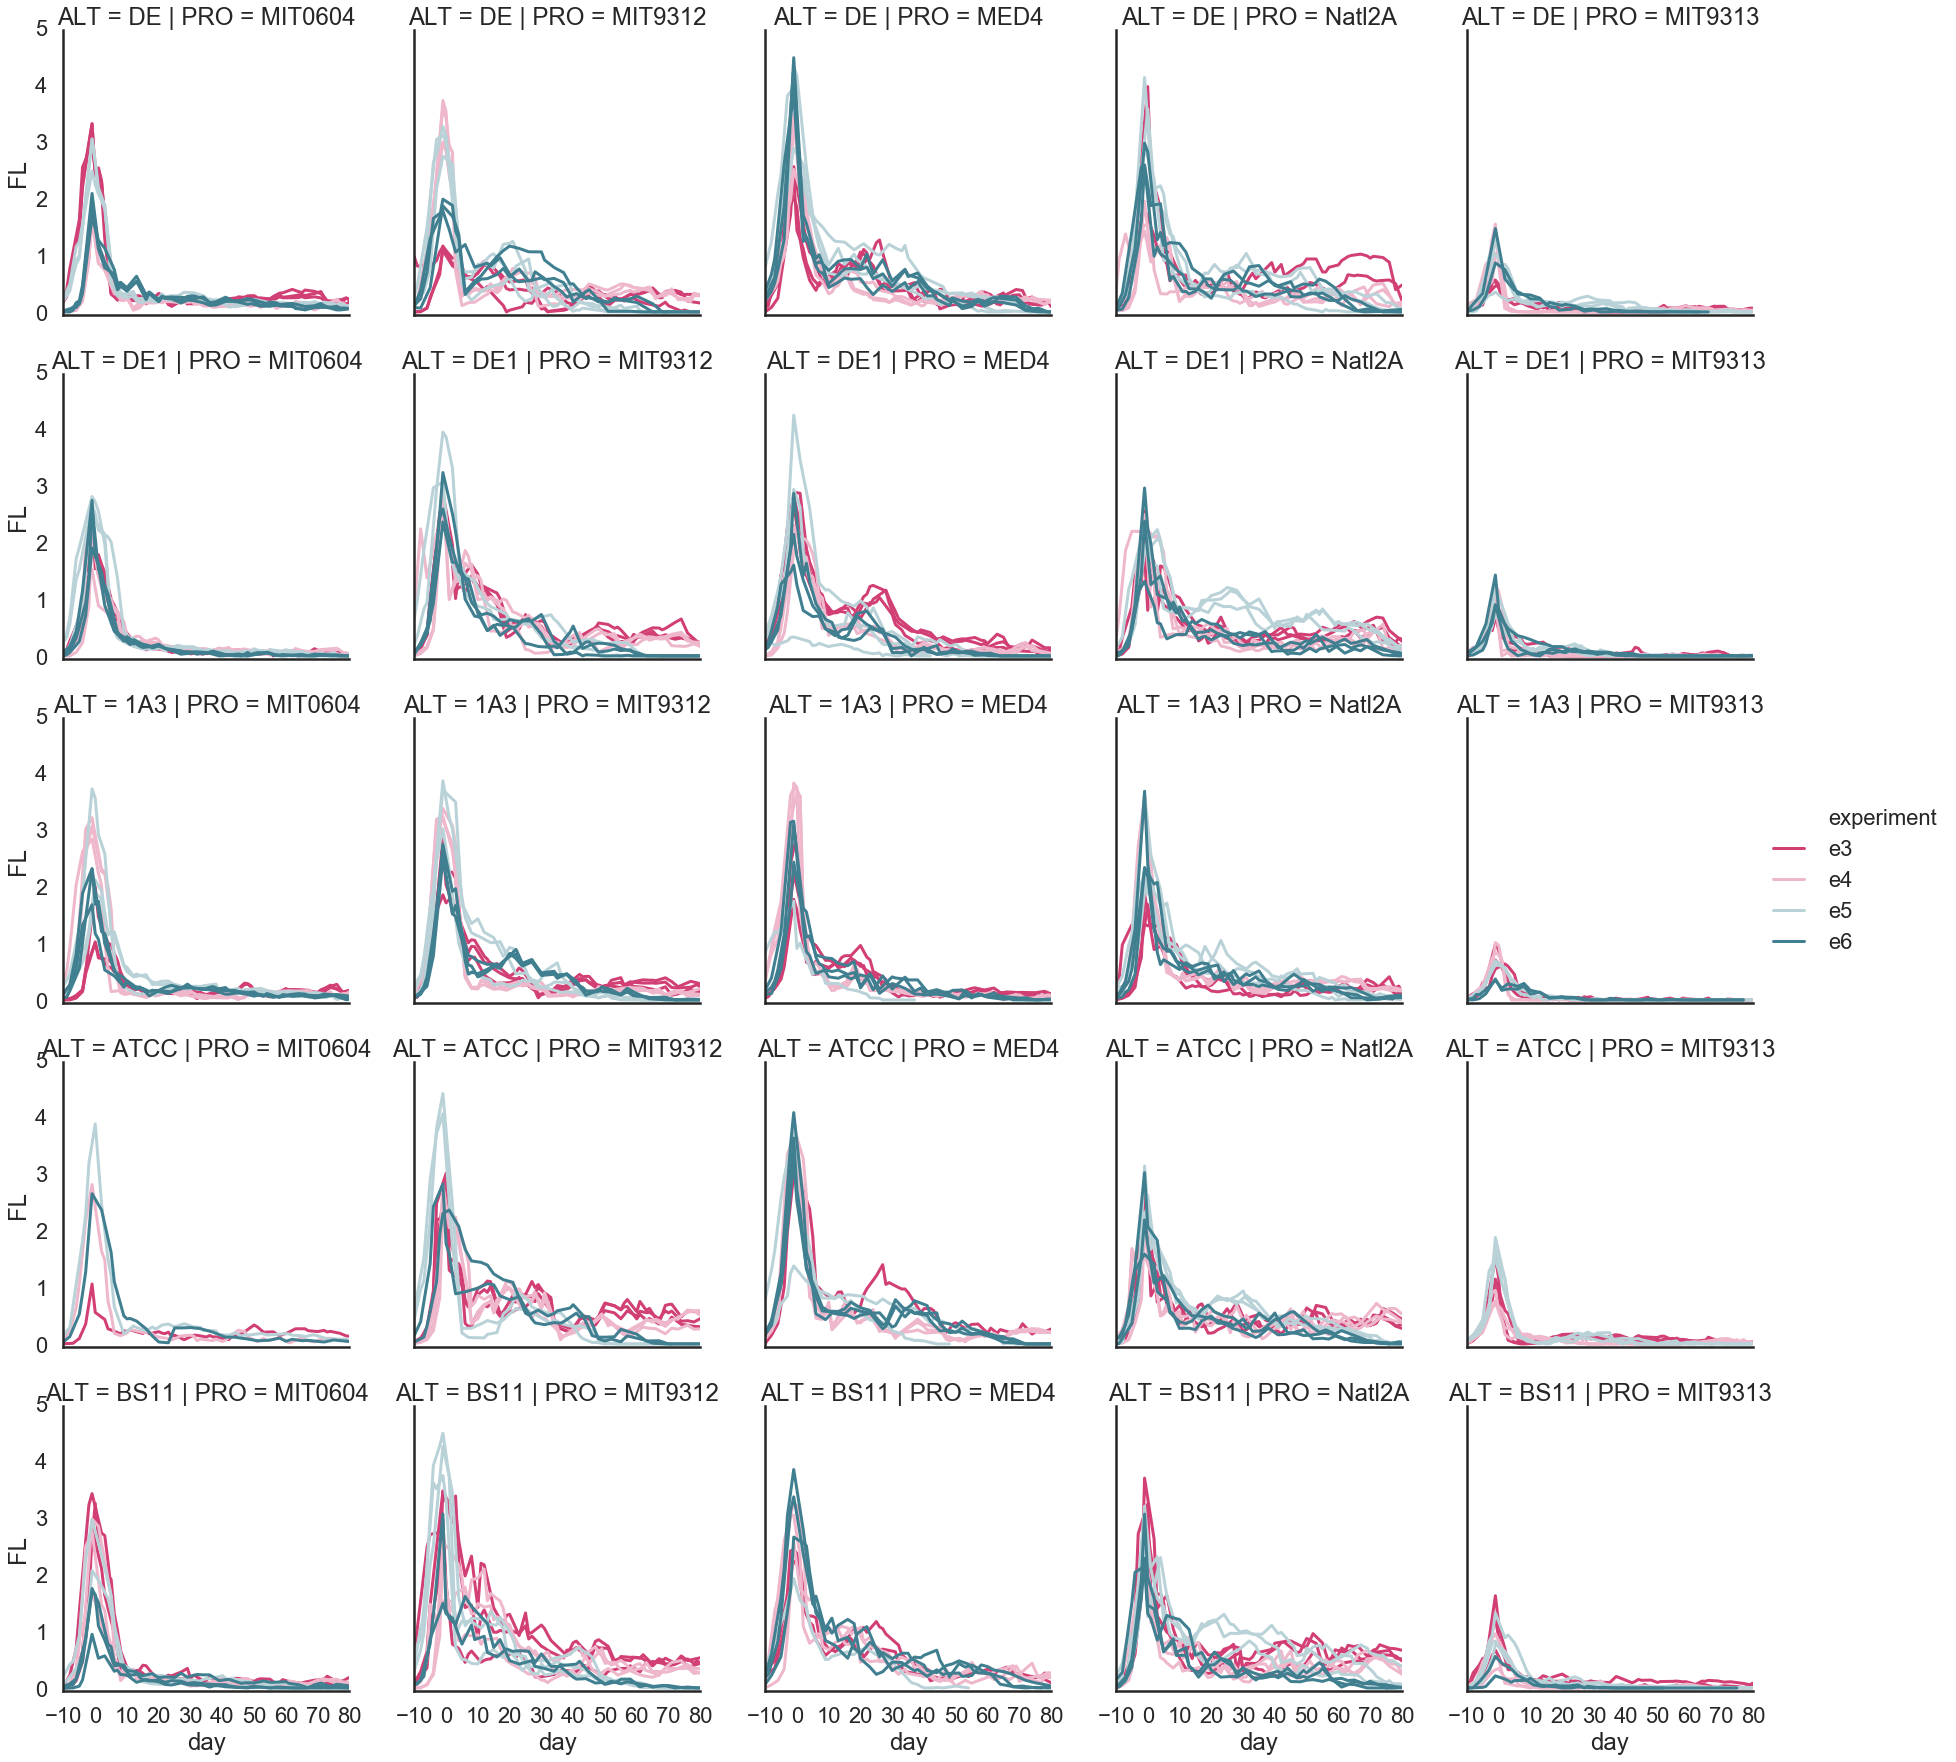

In [18]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

In [19]:
ds['decline'] = ds['FL']

In [20]:
ds34 = ds.loc[ds.experiment.isin(['e3', 'e4'])]
ds56 = ds.loc[ds.experiment.isin(['e5', 'e6'])]

In [21]:
ds34.head()

experiment_sample experiment sample      PRO ALT     culture  day     FL  \
9            e3, 10A         e3    10A  MIT0604  DE  Co_Culture  -10  0.299   
10           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -9  0.381   
11           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -8  0.693   
12           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -7  0.959   
13           e3, 10A         e3    10A  MIT0604  DE  Co_Culture   -6  1.225   

    decline  
9     0.299  
10    0.381  
11    0.693  
12    0.959  
13    1.225

In [22]:
train34_df_orig, test34_df_orig = cp.split_train_test(ds34,test_size=0.4)
train56_df_orig, test56_df_orig = cp.split_train_test(ds56,test_size=0.4)

In [23]:
train34_df = cp.augment_training(train34_df_orig, noise_N=3, augment_x=False)
test34_df = test34_df_orig
train56_df = cp.augment_training(train56_df_orig, noise_N=3, augment_x=False)
test56_df = test56_df_orig

In [24]:
train34_df.shape, test34_df.shape, train56_df.shape, test56_df.shape, 

((642096, 10), (5187, 9), (572880, 10), (4591, 9))

In [25]:
train34_df.loc[train34_df.FL < 0.0001, 'FL'] = 0.0001
train56_df.loc[train56_df.FL < 0.0001, 'FL'] = 0.0001
test34_df.loc[test34_df.FL < 0.0001, 'FL'] = 0.0001
test56_df.loc[test56_df.FL < 0.0001, 'FL'] = 0.0001


C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
train34_df.FL = np.log(train34_df.FL)
test34_df.FL = np.log(test34_df.FL)
train56_df.FL = np.log(train56_df.FL)
test56_df.FL = np.log(test56_df.FL)


C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [27]:
stats34_list = []
y34_list = []
clf34_list = []
features34_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train34_df, test34_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats34_list.extend(res)
y34_list.extend(_y_list)
clf34_list.extend(_clf_list)
features34_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [28]:
stats56_list = []
y56_list = []
clf56_list = []
features56_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train56_df, test56_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats56_list.extend(res)
y56_list.extend(_y_list)
clf56_list.extend(_clf_list)
features56_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [29]:
stats56_df = pd.DataFrame.from_records(stats56_list)
stats34_df = pd.DataFrame.from_records(stats34_list)


In [30]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
24  0.820900       0.826923             1.0
18  0.804302       0.807692             1.0
5   0.804302       0.807692             1.0
13  0.784303       0.788462             1.0
6   0.783970       0.788462             1.0
11  0.781761       0.788462             1.0
23  0.781429       0.788462             1.0
14  0.779746       0.788462             1.0
25  0.779746       0.788462             1.0
16  0.779414       0.788462             1.0

In [31]:
stats34_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
29  0.911602       0.912281             1.0
17  0.911449       0.912281             1.0
26  0.911449       0.912281             1.0
20  0.911449       0.912281             1.0
0   0.911449       0.912281             1.0
2   0.911449       0.912281             1.0
5   0.911099       0.912281             1.0
25  0.893495       0.894737             1.0
18  0.892884       0.894737             1.0
23  0.892884       0.894737             1.0

In [67]:
idx34 = 29
y34_df =  y34_list[idx34]
clf34 = clf34_list[idx34]
features34 = features34_list[idx34]

In [68]:
y34_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred  \
experiment_sample                                               
e3, 10A, FL_0.05_0_first   MIT0604      MIT0604       MIT0604   
e3, 10A, FL_0.05_0_last    MIT0604      MIT0604       MIT0604   
e3, 10A, FL_0.05_0_max     MIT0604      MIT0604       MIT0604   
e3, 10A, FL_0.05_0_mean    MIT0604      MIT0604       MIT0604   
e3, 10A, FL_0.05_0_median  MIT0604      MIT0604       MIT0604   

                          PRO_FL_y_pred_PRO   Type  
experiment_sample                                   
e3, 10A, FL_0.05_0_first            MIT0604  Train  
e3, 10A, FL_0.05_0_last             MIT0604  Train  
e3, 10A, FL_0.05_0_max              MIT0604  Train  
e3, 10A, FL_0.05_0_mean             MIT0604  Train  
e3, 10A, FL_0.05_0_median           MIT0604  Train

accuracy: 0.9122807017543859
              precision    recall  f1-score   support

        MED4       1.00      1.00      1.00        11
     MIT0604       0.91      0.91      0.91        11
     MIT9312       1.00      0.75      0.86        12
     MIT9313       0.92      1.00      0.96        11
      Natl2A       0.79      0.92      0.85        12

    accuracy                           0.91        57
   macro avg       0.92      0.92      0.91        57
weighted avg       0.92      0.91      0.91        57



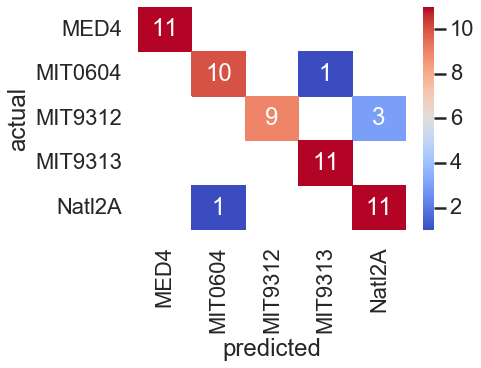

In [69]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y34_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


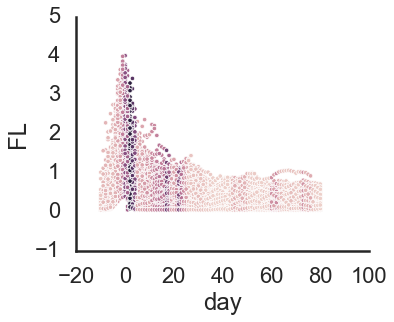

In [70]:
feature_importances34 = pd.DataFrame(clf34.feature_importances_,
                                   index = features34,
                                    columns=['importance'])
merge34df = ds34.merge(feature_importances34, left_on='day', right_index=True, how='left')
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

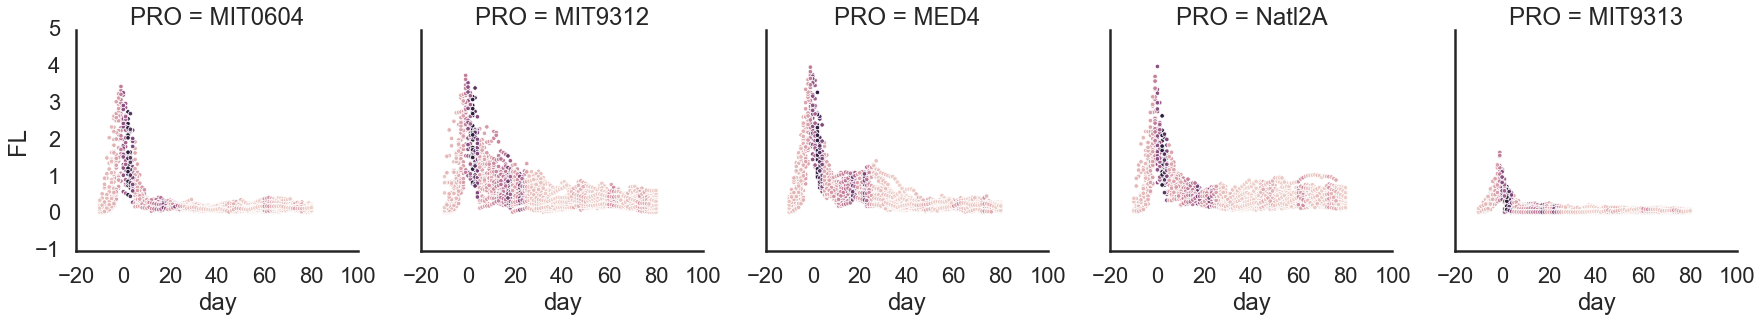

In [71]:
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

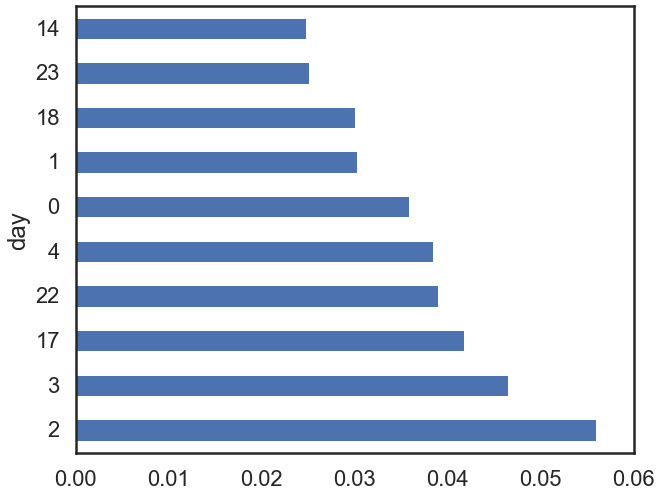

In [72]:
feature_importances34.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [73]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

f1_test  accuracy_test  accuracy_train
24  0.820900       0.826923             1.0
18  0.804302       0.807692             1.0
5   0.804302       0.807692             1.0
13  0.784303       0.788462             1.0
6   0.783970       0.788462             1.0
11  0.781761       0.788462             1.0
23  0.781429       0.788462             1.0
14  0.779746       0.788462             1.0
25  0.779746       0.788462             1.0
16  0.779414       0.788462             1.0

In [74]:
idx56 = 24
y56_df =  y56_list[idx56]
clf56 = clf56_list[idx56]
features56 = features56_list[idx56]

In [75]:
y56_df.head()

PRO_FL_y PRO_FL_y_PRO PRO_FL_y_pred  \
experiment_sample                                               
e5, 10A, FL_0.05_0_first   MIT0604      MIT0604       MIT0604   
e5, 10A, FL_0.05_0_last    MIT0604      MIT0604       MIT0604   
e5, 10A, FL_0.05_0_max     MIT0604      MIT0604       MIT0604   
e5, 10A, FL_0.05_0_mean    MIT0604      MIT0604       MIT0604   
e5, 10A, FL_0.05_0_median  MIT0604      MIT0604       MIT0604   

                          PRO_FL_y_pred_PRO   Type  
experiment_sample                                   
e5, 10A, FL_0.05_0_first            MIT0604  Train  
e5, 10A, FL_0.05_0_last             MIT0604  Train  
e5, 10A, FL_0.05_0_max              MIT0604  Train  
e5, 10A, FL_0.05_0_mean             MIT0604  Train  
e5, 10A, FL_0.05_0_median           MIT0604  Train

accuracy: 0.8269230769230769
              precision    recall  f1-score   support

        MED4       1.00      0.58      0.74        12
     MIT0604       0.78      0.78      0.78         9
     MIT9312       0.92      1.00      0.96        11
     MIT9313       0.75      1.00      0.86         9
      Natl2A       0.75      0.82      0.78        11

    accuracy                           0.83        52
   macro avg       0.84      0.84      0.82        52
weighted avg       0.85      0.83      0.82        52



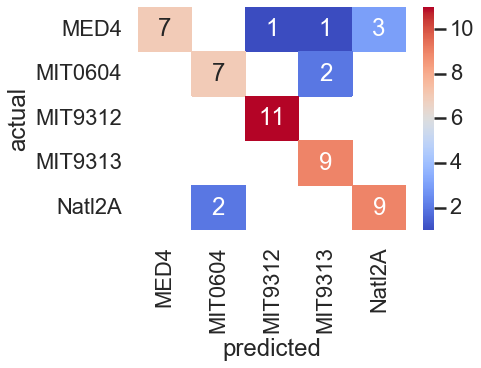

In [76]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y56_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


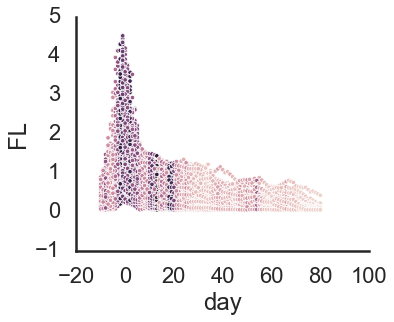

In [77]:
feature_importances56 = pd.DataFrame(clf56.feature_importances_,
                                   index = features56,
                                    columns=['importance'])
merge56df = ds56.merge(feature_importances56, left_on='day', right_index=True, how='left')
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

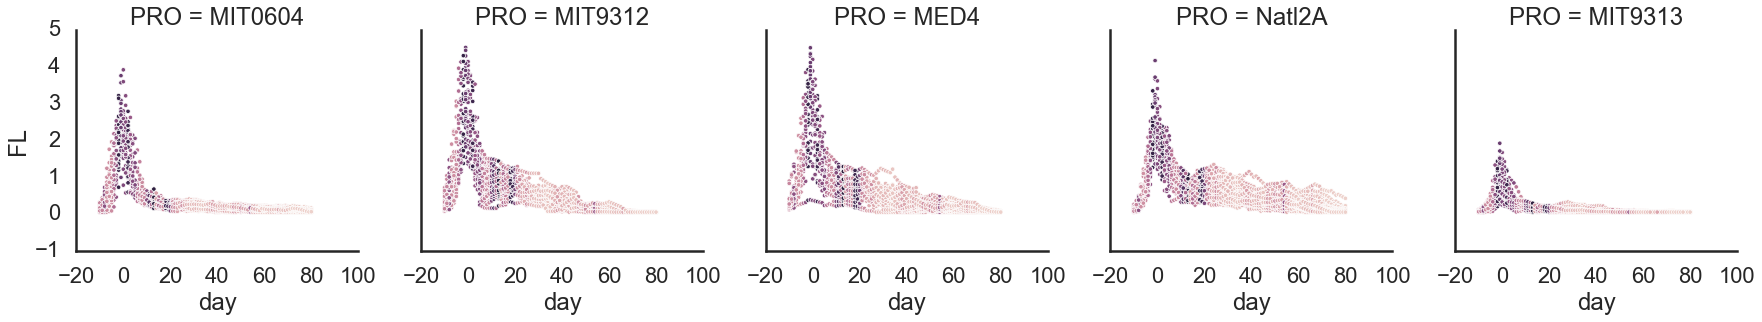

In [78]:
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

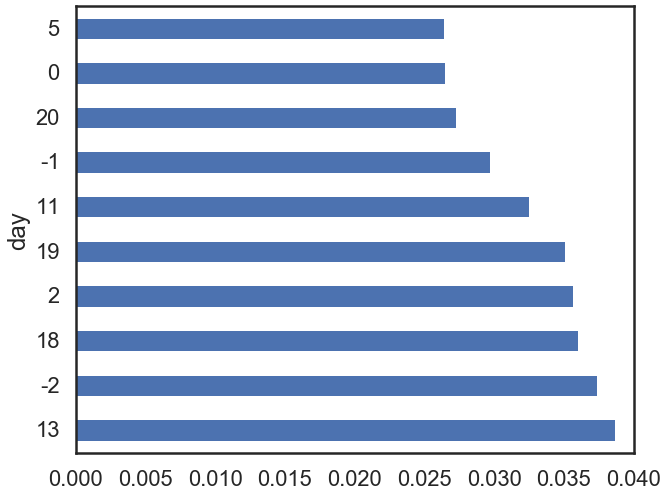

In [79]:
feature_importances56.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [80]:
feature_importances_all34 = pd.DataFrame({
    'day': [v for l in features34_list for v in l],
    'importance' :  [v for l in clf34_list for v in l.feature_importances_ ]
})
feature_importances_all56 = pd.DataFrame({
    'day': [v for l in features56_list for v in l],
    'importance' :  [v for l in clf56_list for v in l.feature_importances_ ]
})



In [81]:
feature_importances_all34.index

RangeIndex(start=0, stop=2730, step=1)

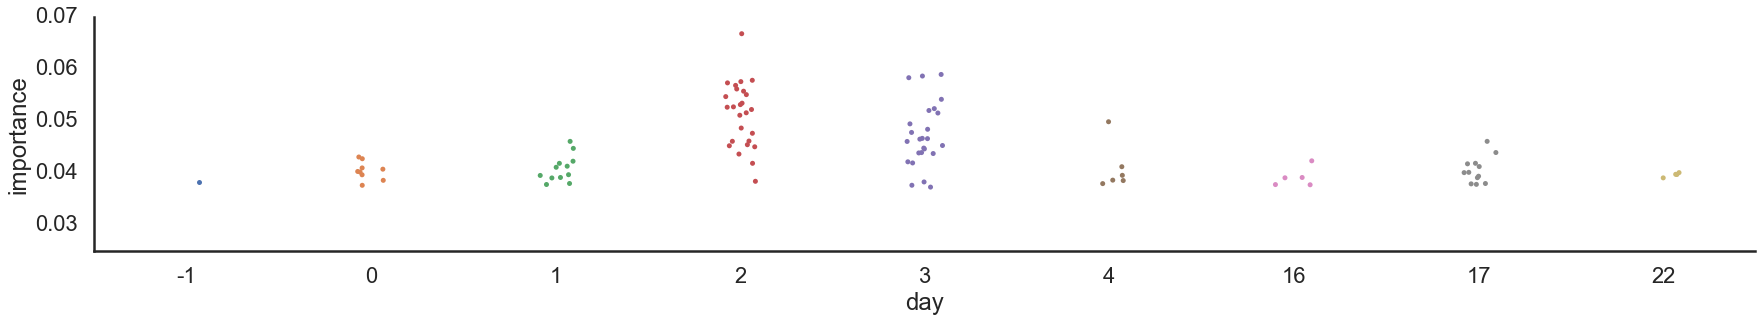

In [82]:
sns.catplot(data=feature_importances_all34.nlargest(columns='importance', n=100), x='day', y='importance',  aspect=5)

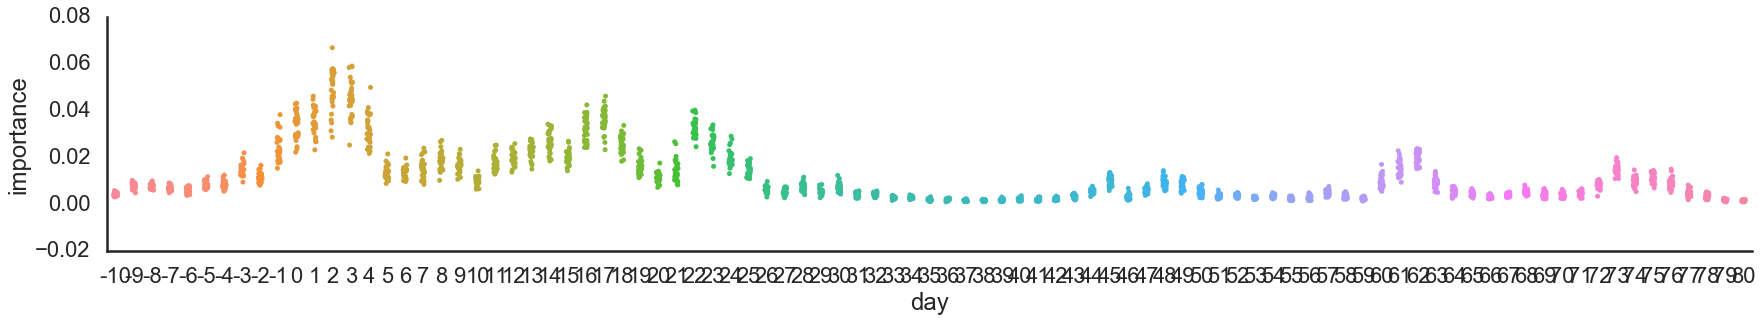

In [83]:
sns.catplot(data=feature_importances_all34, x='day', y='importance',  aspect=5)

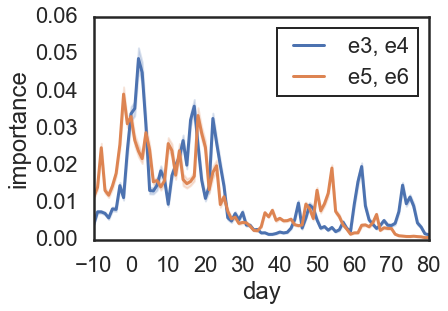

In [84]:
sns.lineplot(data=feature_importances_all34, x='day', y='importance', label='e3, e4')
sns.lineplot(data=feature_importances_all56, x='day', y='importance',   label='e5, e6')

In [50]:
test34_df.FL.describe()

count    5187.000000
mean       -1.274702
std         0.978421
min        -2.995732
25%        -1.966113
50%        -1.257022
75%        -0.650088
max         1.386544
Name: FL, dtype: float64

# cluster by decline

In [51]:
value_col = 'FL'

In [52]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.56457792 0.1723785 ]


In [53]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

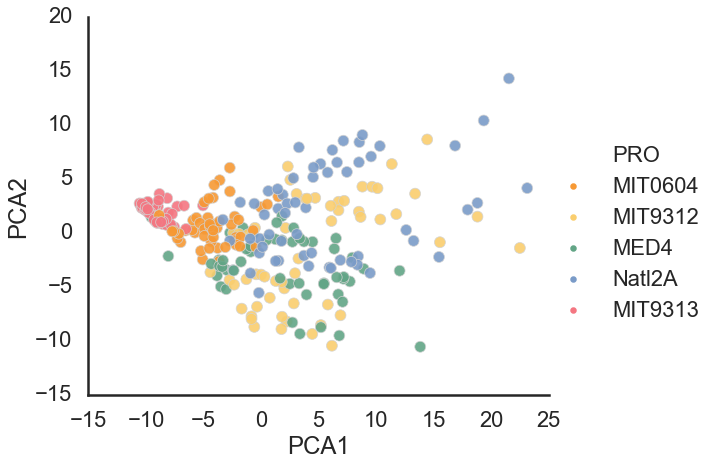

In [54]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

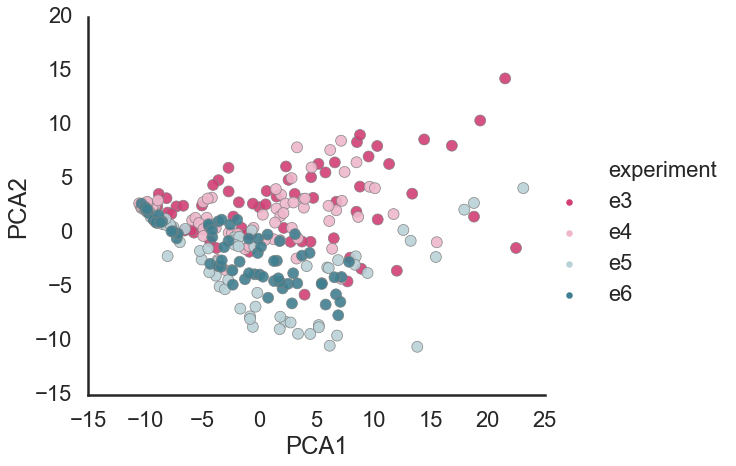

In [55]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

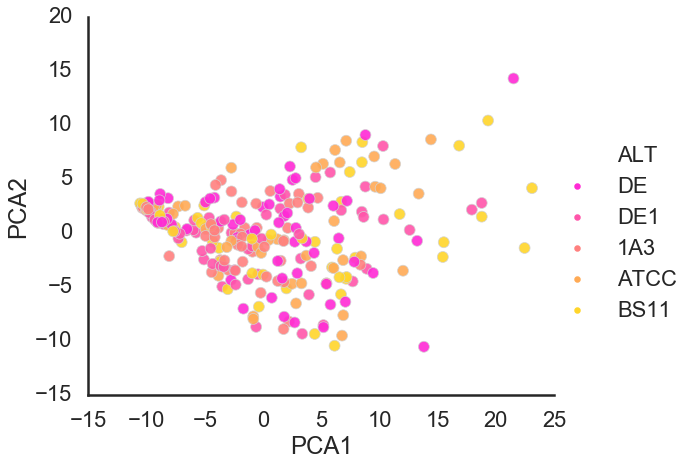

In [56]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

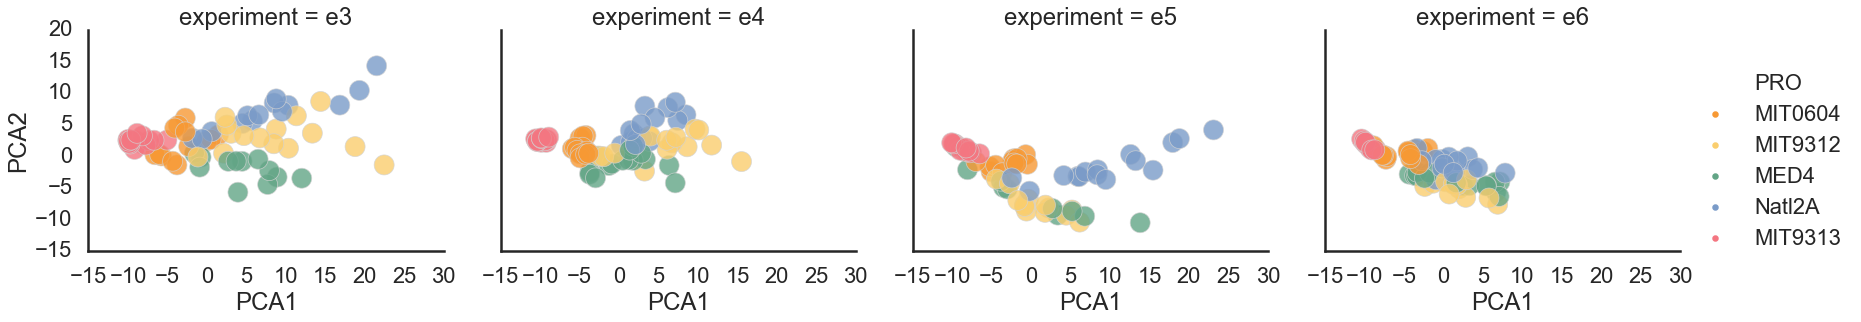

In [57]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

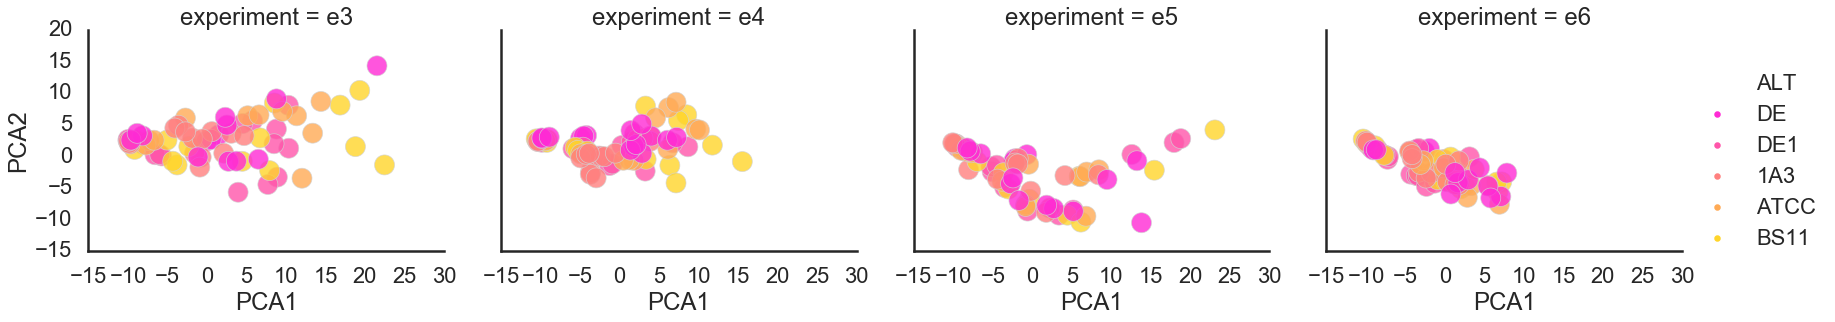

In [58]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

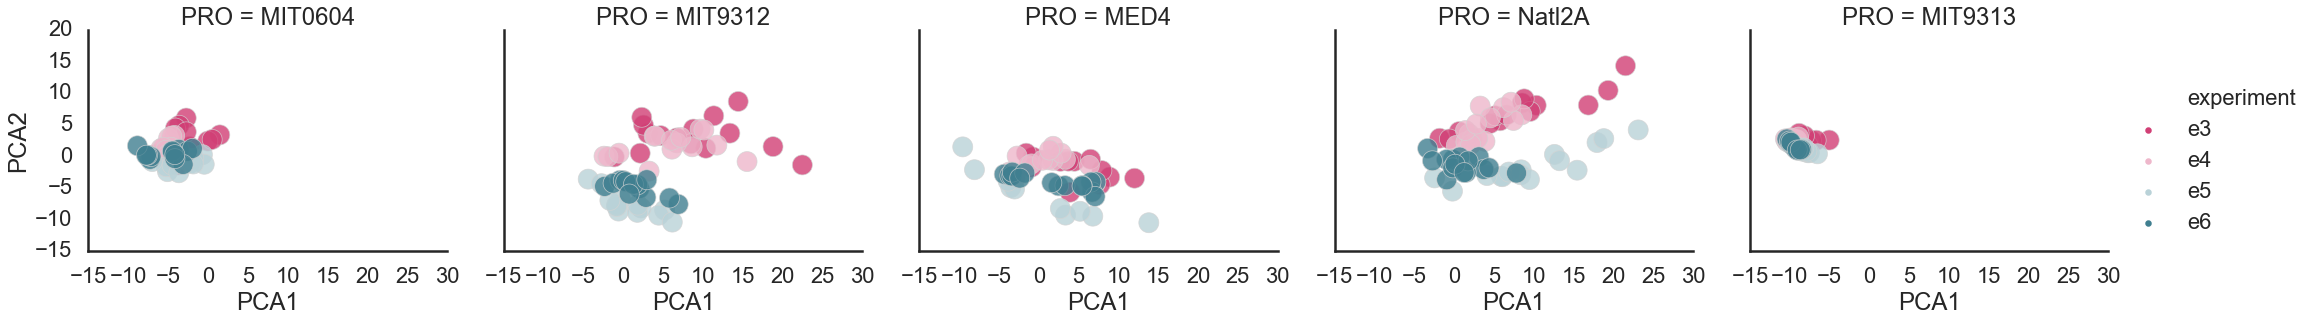

In [59]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [60]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=metadf[col3].nunique())))
row_colors3 = metadf[col3].map(lut3)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


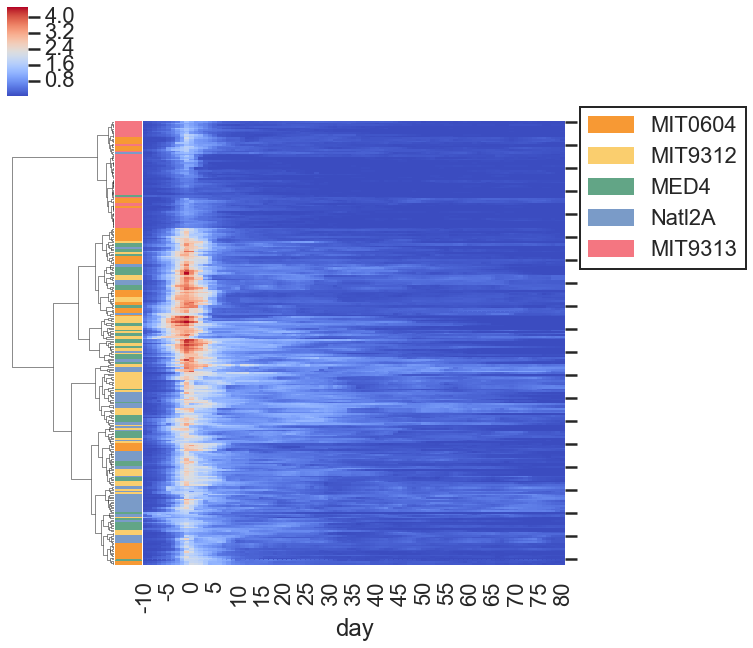

In [61]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

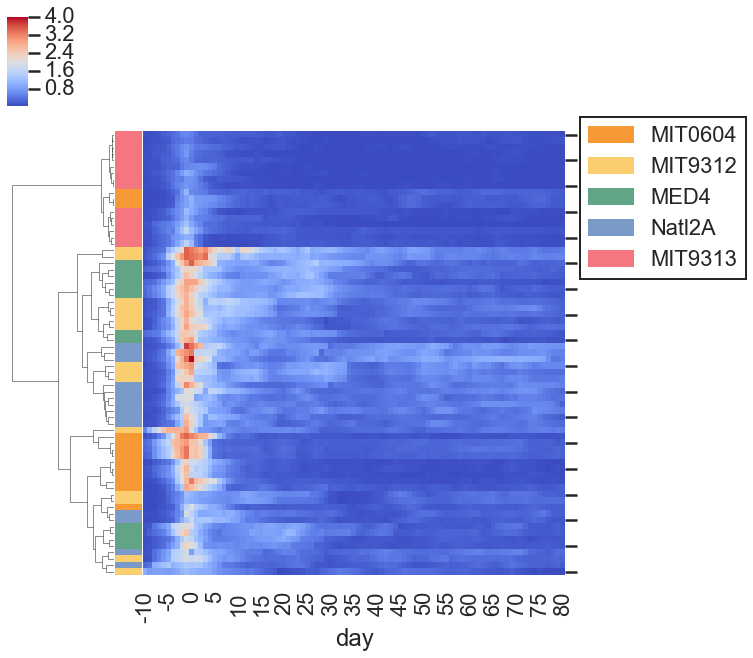

In [62]:
import matplotlib.patches as mpatches
X = cp.experiments2X(ds.loc[ds.experiment == 'e3'], value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds.loc[ds.experiment == 'e3'])
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']

g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                      # row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

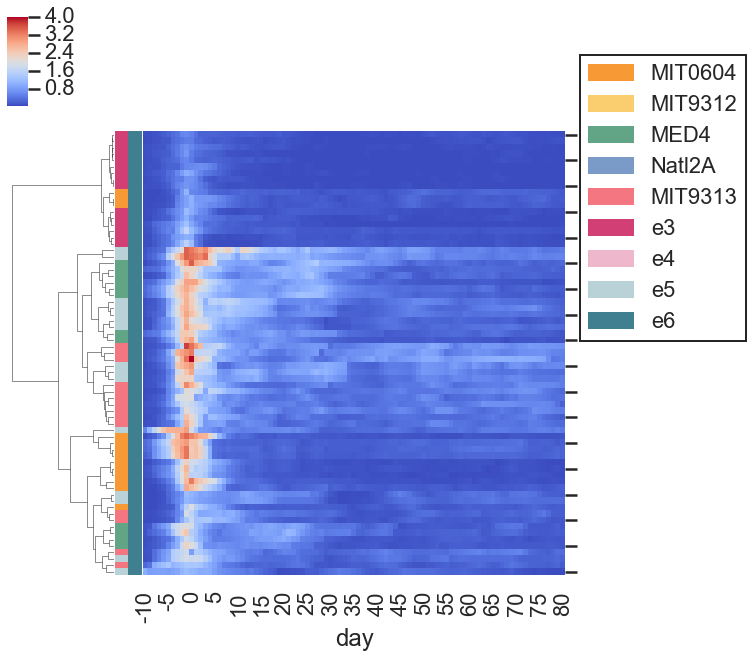

In [63]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

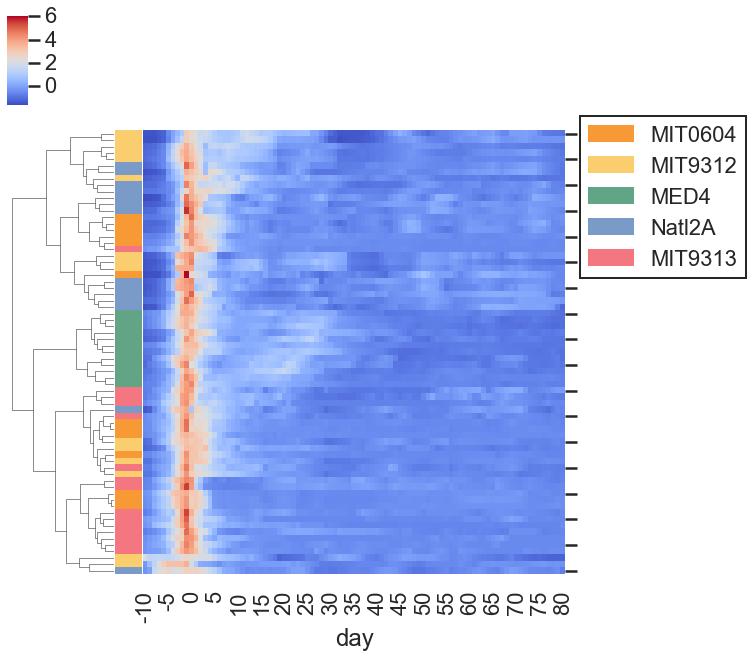

In [64]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=0, 
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

# Analyze Features

In [65]:
from sklearn.linear_model import LogisticRegression


In [66]:
import tsfresh
from tsfresh.utilities.dataframe_functions import impute


ModuleNotFoundError: No module named 'tsfresh'

In [ ]:
def compute_corr(x, y):
    x = x.values.reshape(-1, 1)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(x, y)
    return clf.score(x,y)

In [ ]:
ds34c = cp.update_calculated_fields(ds34, group_col='experiment_sample', add_experiment_sample=False)
ds56c = cp.update_calculated_fields(ds56, group_col='experiment_sample', add_experiment_sample=False)

df_features34 = cp.generate_features(ds34c)
df_features56 = cp.generate_features(ds56c)

In [ ]:
X_features34 = cp.features2X(df_features34)
metadf_features34 = cp.get_meta(df_features34, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features34.index = metadf_features34.experiment_sample
y34 = metadf_features34['PRO']

In [ ]:
X_features56 = cp.features2X(df_features56)
metadf_features56 = cp.get_meta(df_features56, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features56.index = metadf_features56.experiment_sample
y56 = metadf_features56['PRO']

In [ ]:
ts_f_features_df34 = tsfresh.extract_features(
    ds34c.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


In [ ]:
ts_f_features_df56 = tsfresh.extract_features(
    ds56c.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


In [ ]:
ts_f_features_df34 = impute(ts_f_features_df34)
ts_f_features_df56 = impute(ts_f_features_df56)

In [ ]:
scores34 = {c : compute_corr(X_features34[c], y34) for c in X_features34.columns }
scores56 = {c : compute_corr(X_features56[c], y56) for c in X_features34.columns }

In [ ]:
scores34.update({f'ts_{c}' : compute_corr(ts_f_features_df34[c], y34) for c in ts_f_features_df34.columns })
scores56.update({f'ts_{c}' : compute_corr(ts_f_features_df56[c], y56) for c in ts_f_features_df56.columns })


In [ ]:
scores34_df = pd.Series(scores34)
scores56_df = pd.Series(scores56)

In [ ]:
scores34_df.nlargest(20)

In [ ]:
scores56_df.nlargest(20)

In [ ]:
metadf

In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s != 3
    return ['background-color: yellow' if v else '' for v in is_max]

metadf.pivot_table(index=['PRO','ALT'], columns=['experiment'], aggfunc='count', values='sample').style.apply(highlight_max)

In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = len(s) != 3
    return ['background-color: yellow' if v else '' for v in is_max]

metadf.pivot_table(index=['PRO','ALT'], columns=['experiment'], aggfunc='nunique', 
                   values='sample')# .style.apply(highlight_max)